In [21]:
# Phần 1: Import thư viện
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import yfinance as yf

In [34]:
# Phần 2: Dùng thư viện yfinance để tải dữ liệu giá Bitcoin từ Yahoo Finance trong khoảng thời gian từ '2023-01-01' đến '2023-11-22'.
start_date = '2023-01-01'
end_date = '2023-11-22'

# Tải dữ liệu giá Bitcoin từ Yahoo Finance sử dụng thư viện yfinance
df = yf.download('BTC-USD', start=start_date, end=end_date)
print(df.head())
df.shape

[*********************100%%**********************]  1 of 1 completed
                    Open          High           Low         Close  \
Date                                                                 
2023-01-01  16547.914062  16630.439453  16521.234375  16625.080078   
2023-01-02  16625.509766  16759.343750  16572.228516  16688.470703   
2023-01-03  16688.847656  16760.447266  16622.371094  16679.857422   
2023-01-04  16680.205078  16964.585938  16667.763672  16863.238281   
2023-01-05  16863.472656  16884.021484  16790.283203  16836.736328   

               Adj Close       Volume  
Date                                   
2023-01-01  16625.080078   9244361700  
2023-01-02  16688.470703  12097775227  
2023-01-03  16679.857422  13903079207  
2023-01-04  16863.238281  18421743322  
2023-01-05  16836.736328  13692758566  


(325, 6)

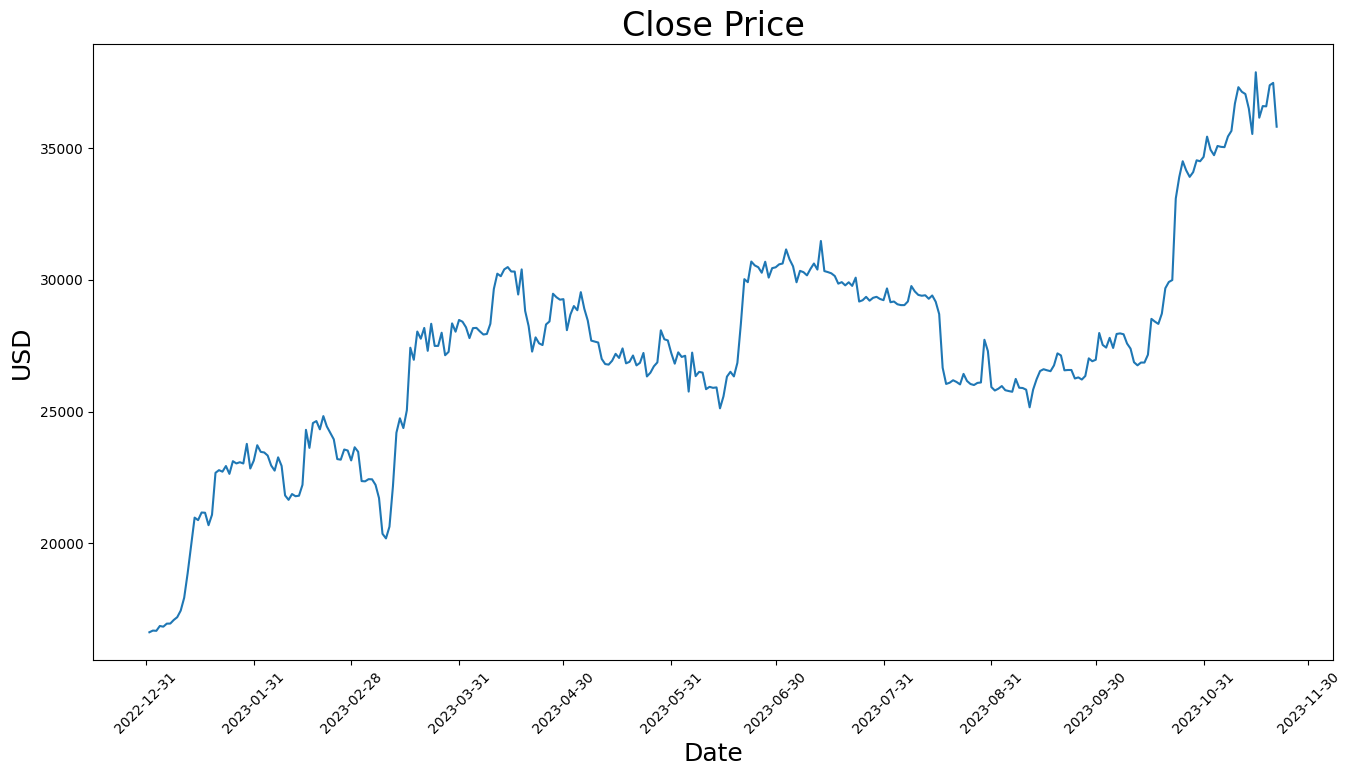

In [23]:
import matplotlib.dates as mdates

# Phần 3: Vẽ đồ thị giá cuối cùng
plt.figure(figsize=(16, 8))
plt.title('Close Price', fontsize=24)

# Định dạng trục x để hiển thị ngày thay vì chỉ số
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=-1))  # Hiển thị ngày cuối cùng của mỗi tháng

# Vẽ biểu đồ
plt.plot(df.index, df['Close'])

plt.xlabel('Date', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.xticks(rotation=45)  # Quay ngày để tránh chồng chéo
plt.show()


In [24]:
# Phần 4: Chuẩn hóa dữ liệu và tạo dữ liệu huấn luyện, sử dụng MinMaxScaler để chuẩn hóa dữ liệu và tạo dữ liệu huấn luyện cho mô hình LSTM. Số lượng ngày được chọn là 60, có thể điều chỉnh.
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
train_data = scaled_data[0:training_data_len, :]
X_train = []
y_train = []

# Tạo dữ liệu huấn luyện
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60: i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [25]:
# Phần 5: Tạo dữ liệu kiểm tra
test_data = scaled_data[training_data_len - 60:, :]
X_test = []
y_test = dataset[training_data_len:, :]

# Tạo dữ liệu kiểm tra
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60: i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [37]:
# Phần 6: Xây dựng và huấn luyện mô hình LSTM (model_1)
tf.random.set_seed(42)

model_1 = Sequential()

# Thêm lớp LSTM với 50 đơn vị, trả về chuỗi đầu ra, kích thước đầu vào là 60 ngày
model_1.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Thêm lớp LSTM thứ hai với 50 đơn vị, không trả về chuỗi đầu ra
model_1.add(LSTM(50, return_sequences=False))

# Thêm lớp Dense với 25 đơn vị
model_1.add(Dense(25))

# Lớp Dense cuối cùng với 1 đơn vị để dự đoán giá
model_1.add(Dense(1))

# Compile mô hình sử dụng optimizer 'adam' và hàm mất mát 'mse'
model_1.compile(optimizer='adam', loss='mse',run_eagerly=True)

# Sử dụng EarlyStopping để dừng sớm nếu không có sự cải thiện đủ
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

# Huấn luyện mô hình với dữ liệu huấn luyện
history = model_1.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
200/200 [==============================] - 73s 366ms/step - loss: 0.0144
Epoch 2/10
200/200 [==============================] - 74s 369ms/step - loss: 0.0053
Epoch 3/10
200/200 [==============================] - 75s 373ms/step - loss: 0.0036
Epoch 4/10
200/200 [==============================] - 74s 371ms/step - loss: 0.0029
Epoch 5/10
200/200 [==============================] - 74s 369ms/step - loss: 0.0026
Epoch 6/10
200/200 [==============================] - 75s 376ms/step - loss: 0.0021
Epoch 7/10
200/200 [==============================] - 75s 375ms/step - loss: 0.0018
Epoch 8/10
200/200 [==============================] - 74s 370ms/step - loss: 0.0018
Epoch 9/10
200/200 [==============================] - 74s 368ms/step - loss: 0.0015
Epoch 10/10
200/200 [==============================] - 75s 372ms/step - loss: 0.0016


3/3 [==============================] - 1s 12ms/step


Text(0.5, 0, 'epochs')

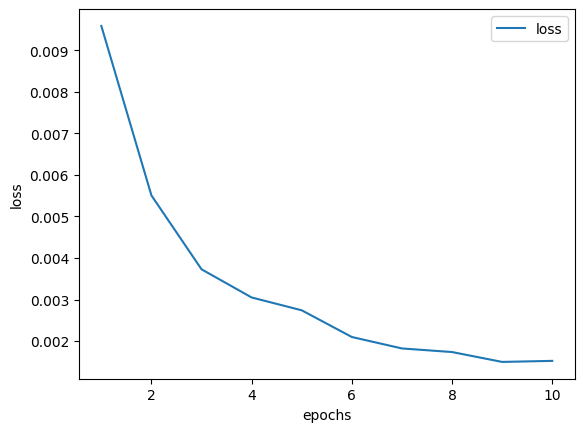

In [27]:
# Phần 7: Dự đoán giá và đánh giá mô hình (model_1) bằng cách sử dụng dữ liệu kiểm tra. Hiển thị giá trị RMSE và vẽ biểu đồ loss qua các epochs.
predictions_1 = model_1.predict(X_test)
predictions_1 = scaler.inverse_transform(predictions_1)
rmse = np.sqrt(np.mean(predictions_1 - y_test)**2)
rmse
historyForPlot = pd.DataFrame(history.history)
historyForPlot.index += 1
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [36]:
# Phần 8: Xây dựng và huấn luyện mô hình thứ hai (model_2)
tf.random.set_seed(42)

model_2 = Sequential()
model_2.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_2.add(LSTM(50, return_sequences=False))
model_2.add(Dense(25))
model_2.add(Dense(1))
model_2.compile(optimizer='Adam', loss='mse',run_eagerly=True)
history_2 = model_2.fit(X_train, y_train, batch_size=1, epochs=6)

Epoch 1/6
200/200 [==============================] - 81s 399ms/step - loss: 0.0090
Epoch 2/6
200/200 [==============================] - 76s 379ms/step - loss: 0.0051
Epoch 3/6
200/200 [==============================] - 76s 379ms/step - loss: 0.0035
Epoch 4/6
200/200 [==============================] - 73s 366ms/step - loss: 0.0028
Epoch 5/6
200/200 [==============================] - 74s 370ms/step - loss: 0.0026
Epoch 6/6
200/200 [==============================] - 74s 370ms/step - loss: 0.0020


In [29]:
# Phần 9: Dự đoán và đánh giá mô hình thứ hai (model_2)
predictions_2 = model_2.predict(X_test)
predictions_2 = scaler.inverse_transform(predictions_2)
rmse_2 = np.sqrt(np.mean(predictions_2 - y_test)**2)
rmse_2

3/3 [==============================] - 1s 12ms/step


697.610546875

<ipython-input-32-27307c7db186>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_1['Predictions'] = predictions_1
<ipython-input-32-27307c7db186>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_2['Predictions'] = predictions_2


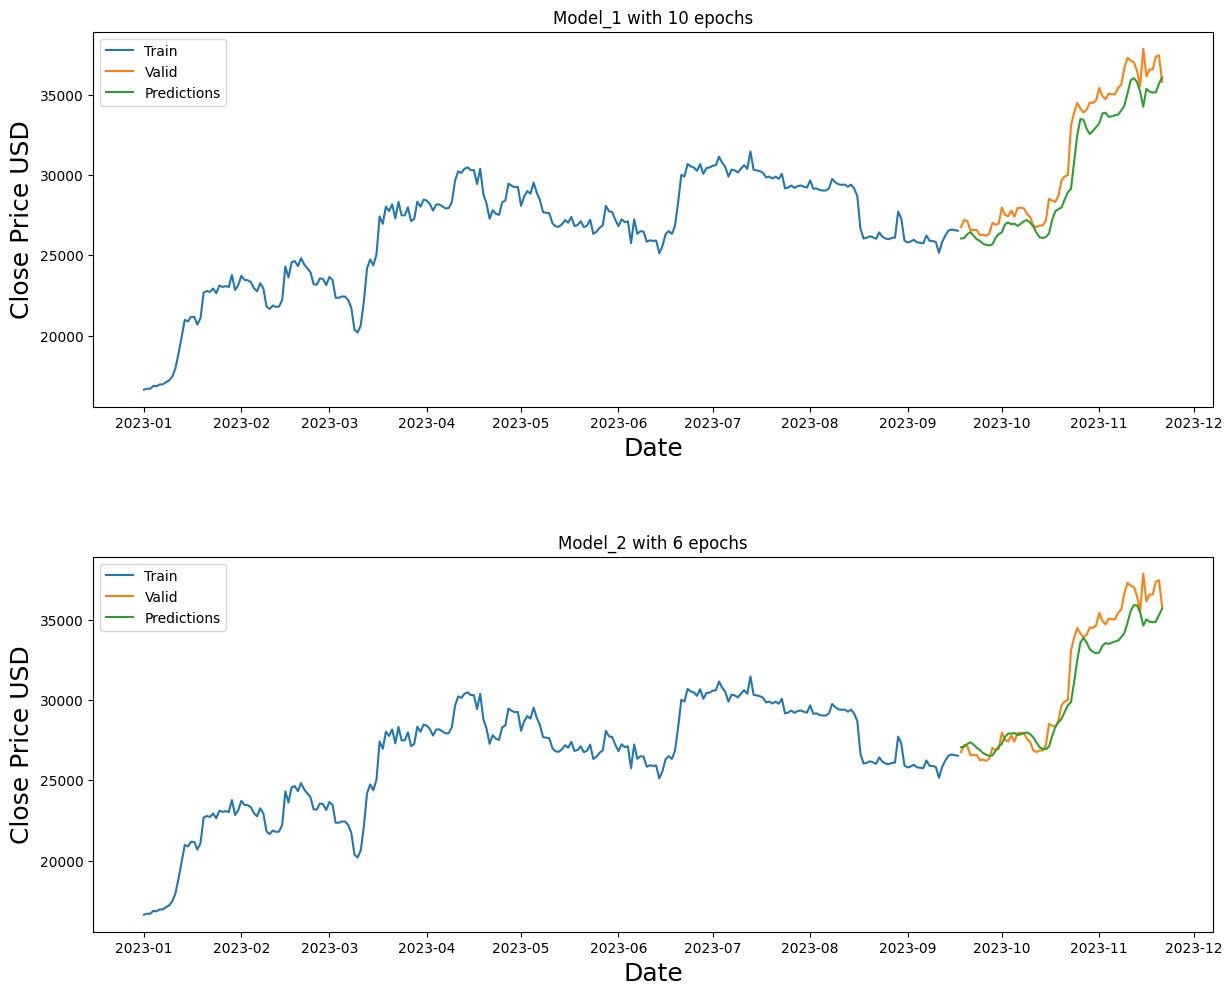

In [32]:
# Phần 10: Trực quan hóa kết quả dự đoán của cả hai mô hình trên dữ liệu kiểm tra.
train = data[:training_data_len]
valid_1 = data[training_data_len:]
valid_1['Predictions'] = predictions_1
valid_2 = data[training_data_len:]
valid_2['Predictions'] = predictions_2

plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title('Model_1 with 10 epochs')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid_1[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')

plt.subplot(2, 1, 2)
plt.title('Model_2 with 6 epochs')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid_2[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=1, wspace=0.4, hspace=0.4)
plt.show()


In [33]:
# Phần 11:  Dự đoán giá Bitcoin trong 60 ngày tiếp theo sử dụng mô hình đầu tiên (model_1).
last_60_days = data[-30:].values
last_60_days_scaled = scaler.fit_transform(last_60_days)
new_X_test = []
new_X_test.append(last_60_days_scaled)
new_X_test = np.array(new_X_test)
new_X_test = np.reshape(new_X_test, (new_X_test.shape[0], new_X_test.shape[1], 1))
pred_price = model_1.predict(new_X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

1/1 [==============================] - 1s 1s/step
[[36351.76]]


In [38]:
model_1.save('model_1.h5')
